# Demonstration of Parareal algorithm using Lorenz 63 System

Parallelisation of PDEs is traditional done via domain composition in the spatial domain. However, parallelisation in the time domain will allow full utilisation of the next generation HPC resources reach exaflop ($10^{18}$) (referred to as exascale computing). 

## Parareal method
Let us consider a PDE of a type 
\begin{equation}
\frac{\partial y}{\partial t} - H(y) = 0 
\label{eqn:pde} \tag{1}
\end{equation}


with $y(t_0) = y_0$, $t \in [t_0,T]$ and $H$ is some operator. The time interval can be decomposed into N sub-intervals $[t_{i-1},ti], t_i = t_0 + i\Delta t$ and $i = 1,2,...,N$, $T=t_0+N\Delta t$. Let $F$ be a numerical integrator that propagates the solution for time $\Delta t$ using a time step $\delta t << \Delta t$. This is referred to as the *fine propagator*, 

\begin{equation}
u_i = F(u_{i-1})
\label{eqn:fine} \tag{2}
\end{equation}

with $u_0=y_0$. This provides a numerical solution to equation $\eqref{eqn:pde}$.

Our aim is to solve equation $\eqref{eqn:pde}$ for each time step $\Delta t$ in parallel. Each of these fine propagators runnning in parallel will require initial conditions $u_i (i > 0)$, which are provided by another, coarse, numerical integrator (or the *coarse propagator*).

\begin{equation}
\tilde{u} = G(\tilde{u}_{i-1}),  
\label{eqn:coarse} \tag{3}
\end{equation}

with $\tilde{u}_0 = y_0$. The coarse propagator is chosen such that it much faster to evaluate than $F$. This can often be the fine propagator, but with a bigger time step.

The parareal algorithm begins (iteration 0) with a sequential application of equation $\eqref{eqn:coarse}$ for $i = 1,2,...,N$ whcih provides $\tilde{u}_i^0$. Then processors $i=1,2,...,N$ solve $\hat{u}_0^0 = F(\tilde{u}_{i-1}^0)$ in parallel. At this point, $\hat{u}_1^0$ is accurate, with respect to $F$, since $\tilde{u}_0^0 = y_0$, which is the initial condition of the PDE. Now a sequential coarse propagator is applied, with a correction term applied at each sub-interval in time, $u_i^1 = G(u_{i-1^1} + \hat{u}_i^0 - \tilde{u}_i^0$. The $u_i^1$ estimate provides the initial conditions for fine propagator in the next iteration. Therefore, in general we have:

\begin{equation}
u_i^k = G(u_{i-1}^k + F(u_{i-1}^{k-1} - G(u_{i-1}^{k-1})
\label{eqn:paralgo} \tag{4}
\end{equation}

where $u_0^k = y_0, i = 1,2,...,N$ and $k=1,2,...,K$. Iteration k consists of parallel propagation $F(u_{i-1}^{k-1}$ followed by sequential propagation $G(u_{i-1}^k)$ corrected according to equation $\eqref{eqn:paralgo}$. This process is repeated until the solution converges i.e. $|u_i^k - u_i^{k-1}| < \epsilon$ where is $\epsilon$ is error tolerance.




## Parareal method in Python code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
# %matplotlib inline

In [2]:

class Parareal():
    """
    Parallel-in-time algorithm
    """

    def __init__(self, integrator):
        """
        Initialise the Parareal instance with the integrator
        """
        self.solver = integrator
    
    def integratorStep(self,I,deltat,y0, f, **f_kwargs):
        """
        single step of the integrator
        """
        # initial coarse integration solution
        y = I(deltat, y0, f, **f_kwargs)
        return y
    
    def parareal(self, y0, nG, nF, deltaG, deltaF, K, f, **f_kwargs):
        """
        Parareal calculation
        nG coarse grid points
        nF fine grid points
        deltaG coarse grid delta t
        deltaF fine grid delta t 
        K number of parallel iterations
        f function being integrated
        returns corrected solution, corrections
        """
        y0 = np.array(y0)
        y0_extend = y0.reshape((1,1,)+y0.shape)
        yG_init = y0_extend.repeat(K,1)
        yG = np.empty(((nG+1,K,)+(y0.shape))) 
        yG[0] = yG_init[0]
        # Initial coarse run through 
        for i in range(1,nG+1):
            yG[i,0,...] = self.integratorStep(self.solver, deltaG, yG[i-1,0,...], f, **f_kwargs)
        
        # Array to save corrected coarse propagator estimates
        yG_correct = yG.copy()
        
        correction = np.empty(((nG,K,int(nF/nG)+1,)+(y0.shape)))
        correction[0,:,0,...] = yG_init[0,:] 

        for k in range(1,K):
            #run fine integrator in parallel for each k interation
            for i in range(nG):
                correction[i,k,0,...] = yG_correct[i,k-1,...]  
                for j in range(1,int(nF/nG)+1): # This is for parallel running
                    correction[i,k,j,...] = self.integratorStep(self.solver, deltaF, correction[i,k,j-1,...],f,**f_kwargs)  
            # Predict and correct 
            for i in range(nG):
                yG[i+1,k,...] = self.integratorStep(self.solver, deltaG, yG_correct[i,k,...],f,**f_kwargs) 
                yG_correct[i+1,k,...] = yG[i+1,k,...] - yG[i+1,k-1,...] + correction[i,k,-1,...]

        return yG_correct, correction



## Applying the parareal algorithm to Lorenz 63 system

In [3]:
def lorenz63(xin,sigma=10,beta=8/3,rho=28):
    """
    Given:
       x, y, z: a point of interest in three dimensional space
       sigma, rho, beta: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    """
    x,y,z = xin
    xdot = sigma * (y - x)
    ydot = x*(rho - z) - y 
    zdot = x*y - beta*z
    return np.array([xdot, ydot, zdot])

In [4]:
def rk4_step(dt, x, f, **f_kwargs):
    """
    A single timestep for function f using RK4
    """
    x1 = f(x, **f_kwargs)  

    x2 = f(x+x1*dt/2.0, **f_kwargs)
    x3 = f(x+x2*dt/2.0, **f_kwargs)
    x4 = f(x+x3*dt, **f_kwargs)
    x_n = x + dt*(x1 + 2*x2 + 2*x3 + x4)/6.0
    return x_n

In [5]:
def run_parareal_l63():
    a = 0
    b = 10.
    # Number of coarse resolution timesteps
    nG = 180 
    # number of fine resolution timesteps
    nF = 14400 
    # Number of parareal iterations
    K = 20
    # Model initial conditions
    y0 = [5,-5,20]
    # coarse grid
    xG = np.linspace(a,b,nG+1)
    deltaG = (b-a)/nG
    # yG shape (n_samples, n_vars)
    xF = np.zeros((nG, int(nF/nG)+1))
    # fine grid, for each coarse grid interval
    for i in range(nG):
        left,right = xG[i], xG[i+1]
        xF[i,:] = np.linspace(left,right,int(nF/nG)+1) 
     
    deltaF = xF[0,1] - xF[0,0]
    f_kwargs = {"sigma" : 10, "beta" : 8/3, "rho" : 28}
    pr = Parareal(rk4_step)
    # returns corrected solution and the correction
    yG_correct, correction = pr.parareal(y0, nG, nF, deltaG, deltaF, K, lorenz63, **f_kwargs)
    
    for i in range(K):
        ax1,ax2,ax3 = plt.figure(figsize=(10,8)).subplots(3,1)
        ax1.plot(xG[1:], yG_correct[1:,i,0], '-o', lw=1.5, label="x")
        ax2.plot(xG[1:], yG_correct[1:,i,1], '-o', lw=1.5, label="y")
        ax3.plot(xG[1:], yG_correct[1:,i,2], '-o', lw=1.5, label="z")
        ax1.plot(xG[1:], correction[:,i,-1,0], '-o', lw=1.5, label="x corr")
        ax2.plot(xG[1:], correction[:,i,-1,1], '-o', lw=1.5, label="y corr")
        ax3.plot(xG[1:], correction[:,i,-1,2], '-o', lw=1.5, label="z corr")
        ax1.set_ylabel("X")
        ax2.set_ylabel("Y")
        ax3.set_ylabel("Z")
        ax3.set_xlabel("Time")
        ax1.set_title(f"Lorenz Attractor: iteration {i}")
        ax1.legend()
        ax2.legend()
        ax3.legend()
        #plt.savefig(f"iteration_mod_{i}.png")
        plt.show()

    for i in range(K):
        ax1,ax2,ax3 = plt.figure(figsize=(10,8)).subplots(3,1)
        ax1.plot(xG[1:], yG_correct[1:,i,0]-correction[:,i,-1,0], '-o', lw=1.5, label="x")
        ax2.plot(xG[1:], yG_correct[1:,i,1]-correction[:,i,-1,1], '-o', lw=1.5, label="y")
        ax3.plot(xG[1:], yG_correct[1:,i,2]-correction[:,i,-1,2], '-o', lw=1.5, label="z")
        ax1.set_ylabel("X")
        ax2.set_ylabel("Y")
        ax3.set_ylabel("Z")
        ax3.set_xlabel("Time")
        ax1.set_title(f"Lorenz Attractor: iteration {i}")
        ax1.legend()
        ax2.legend()
        ax3.legend()
        #plt.savefig(f"iteration_diff_mod_{i}.png")
        plt.show()

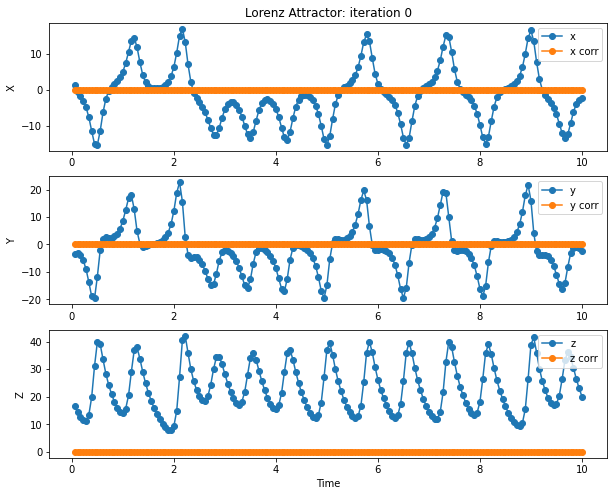

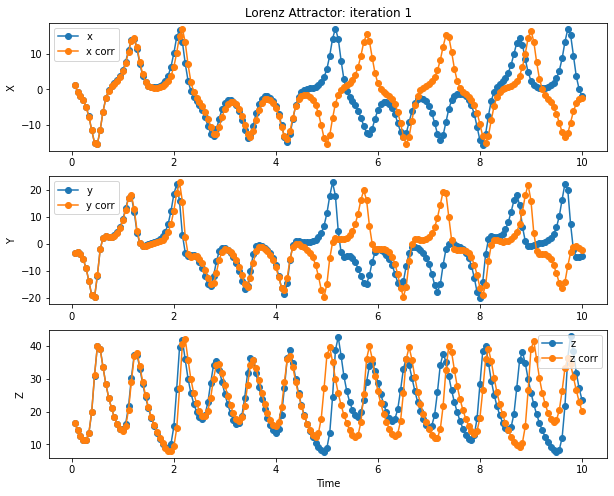

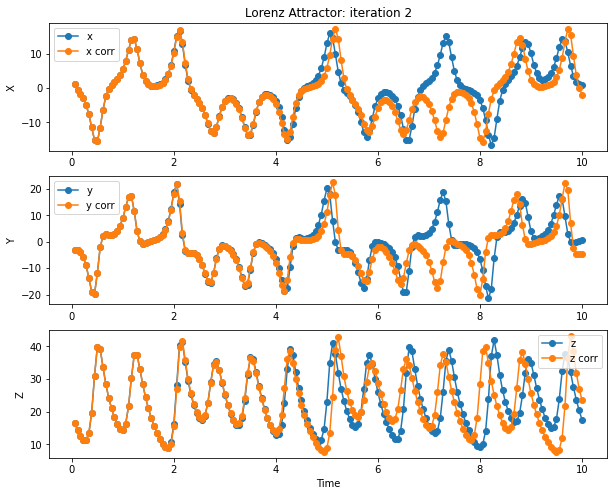

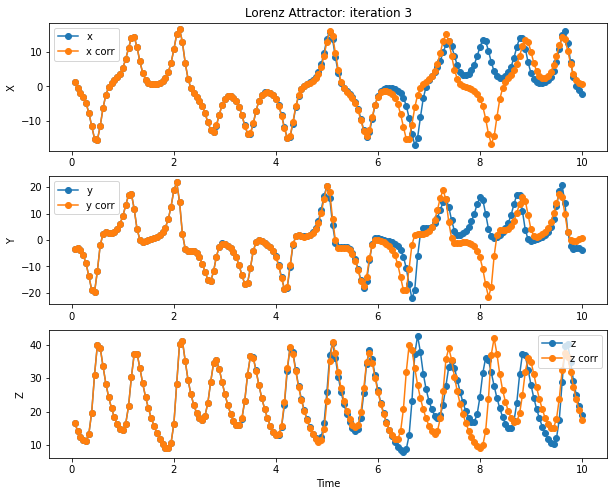

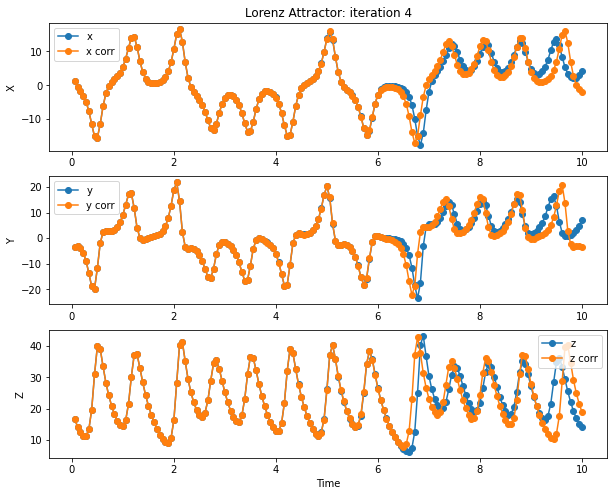

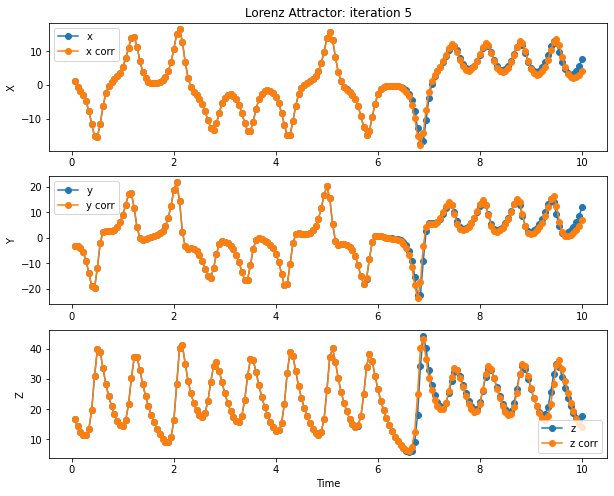

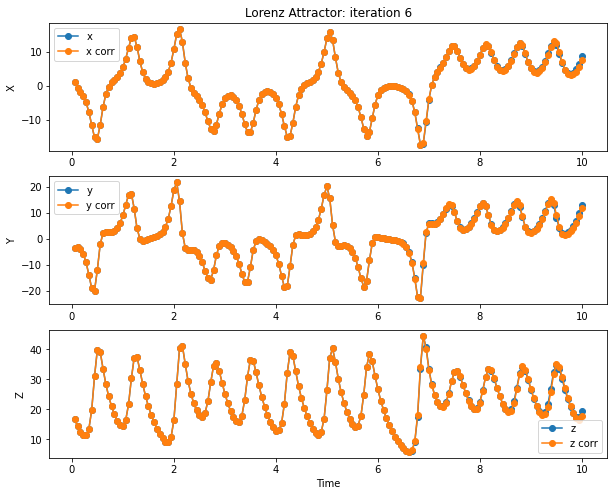

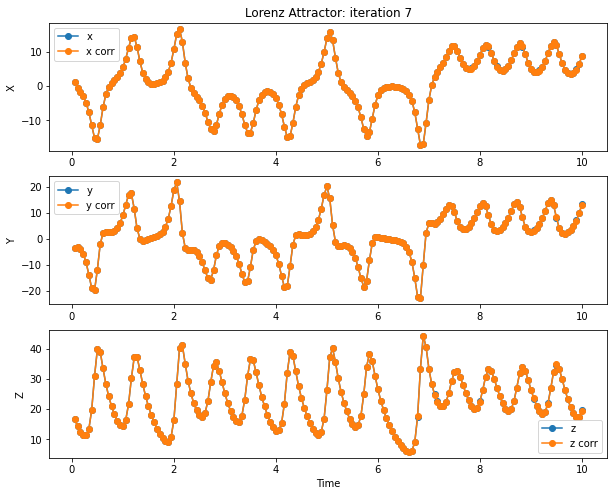

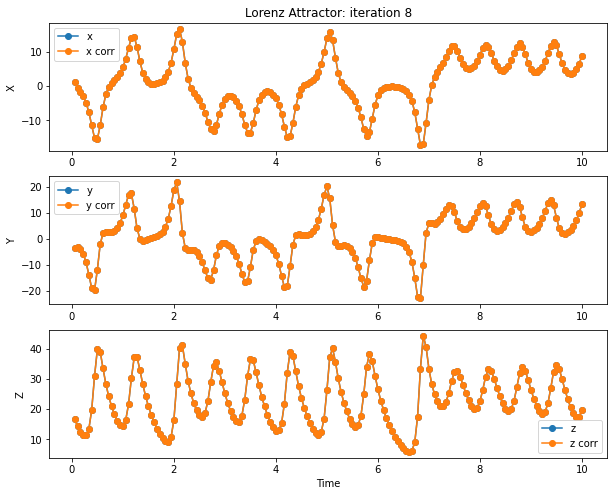

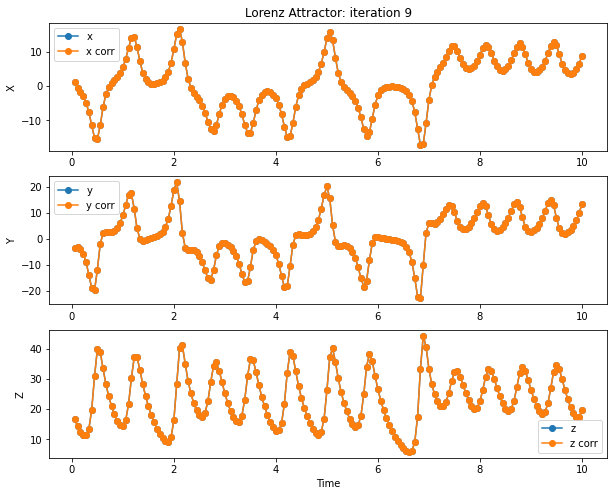

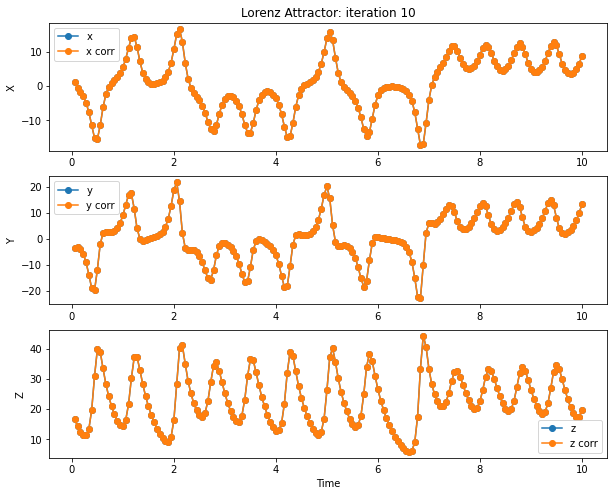

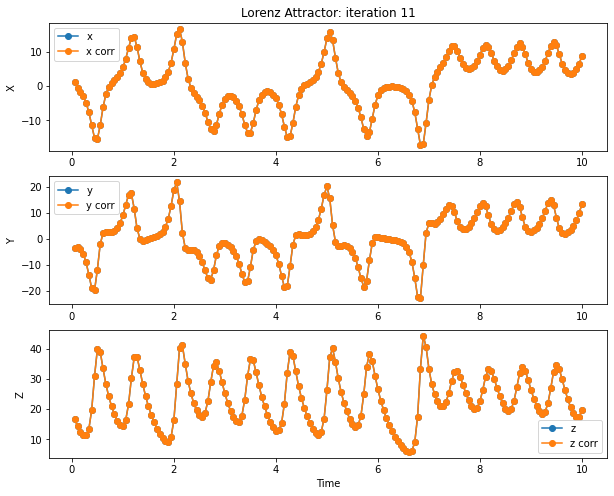

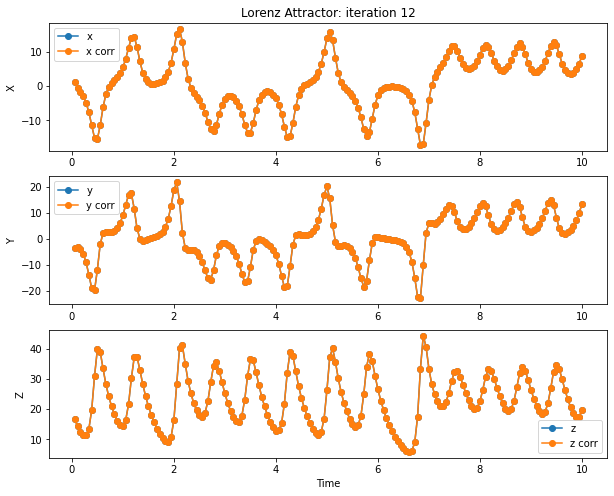

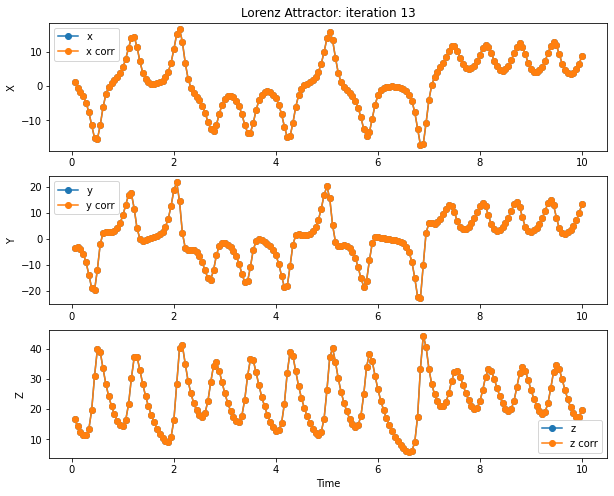

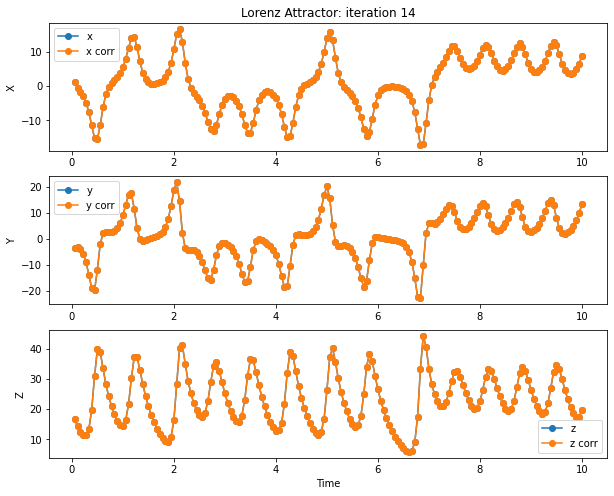

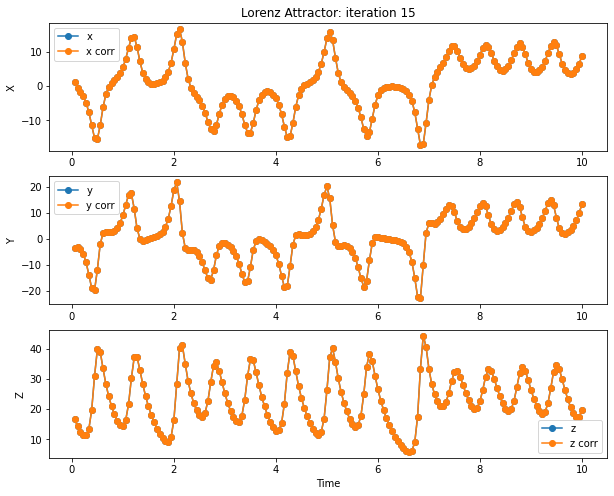

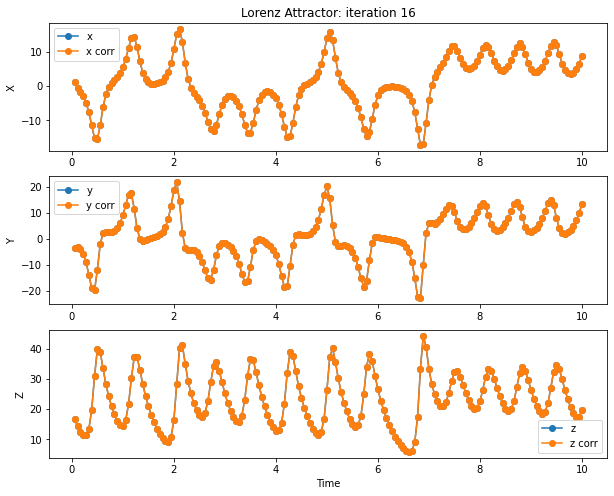

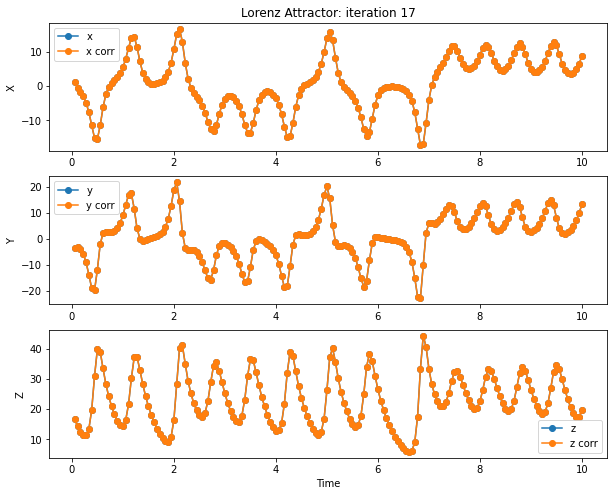

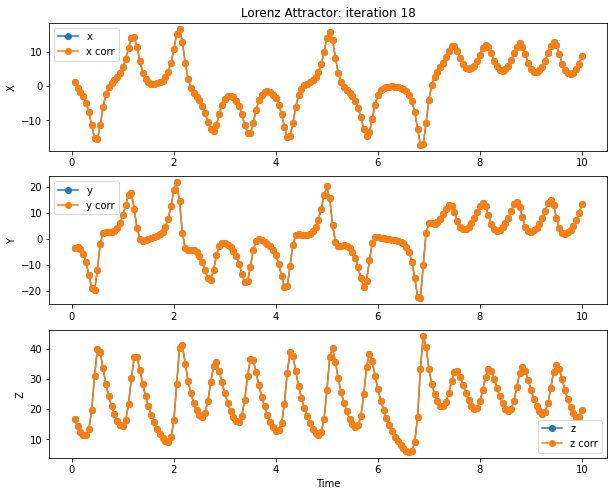

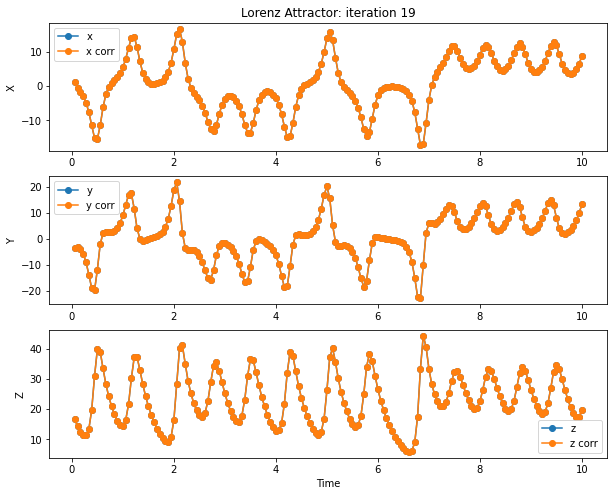

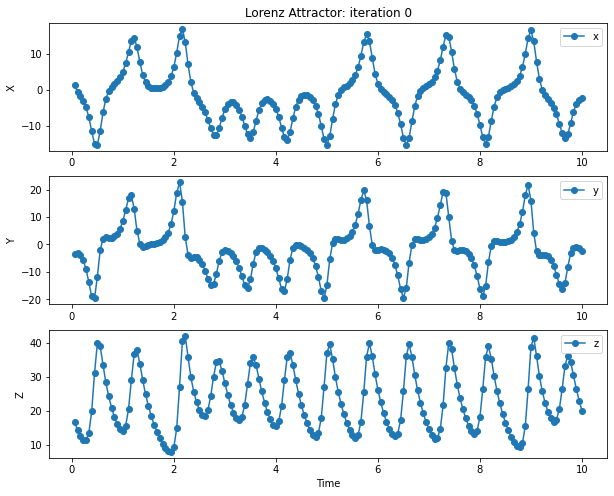

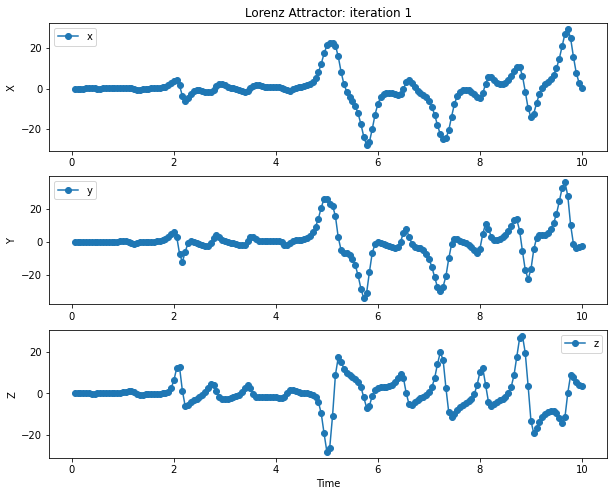

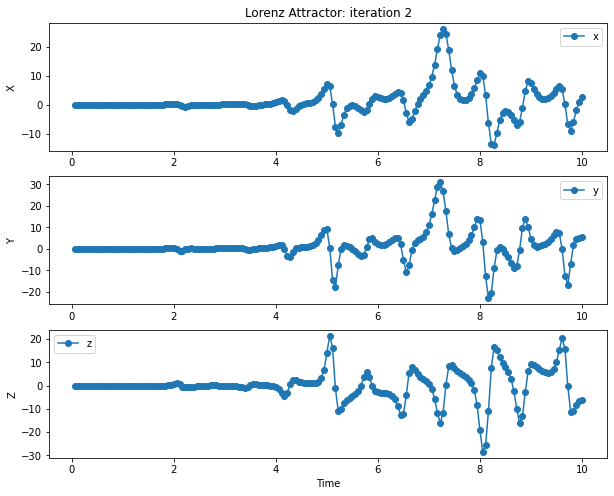

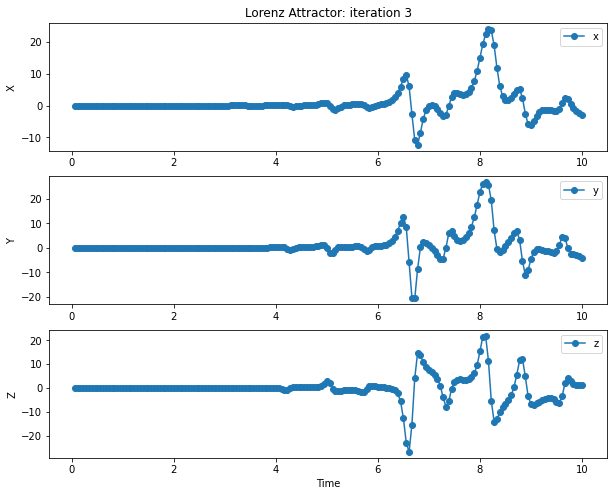

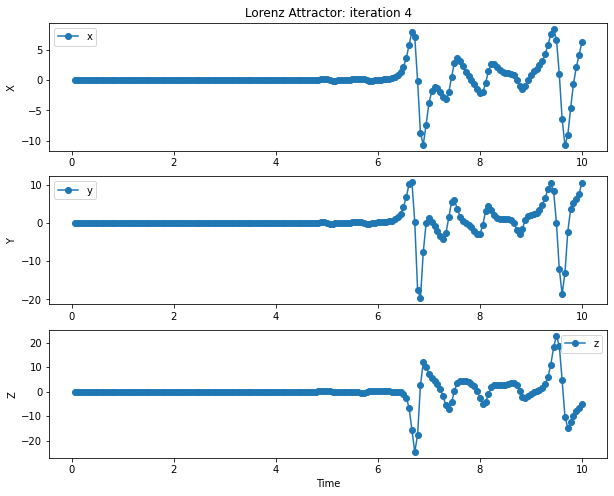

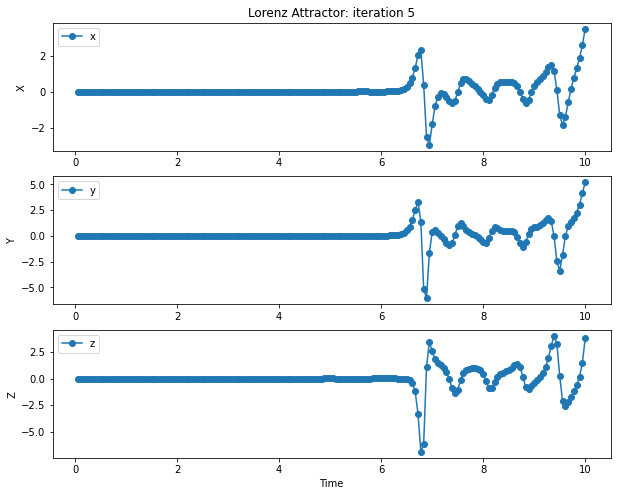

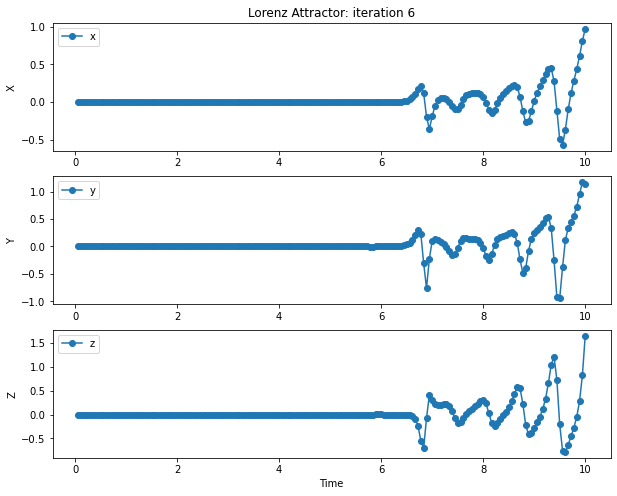

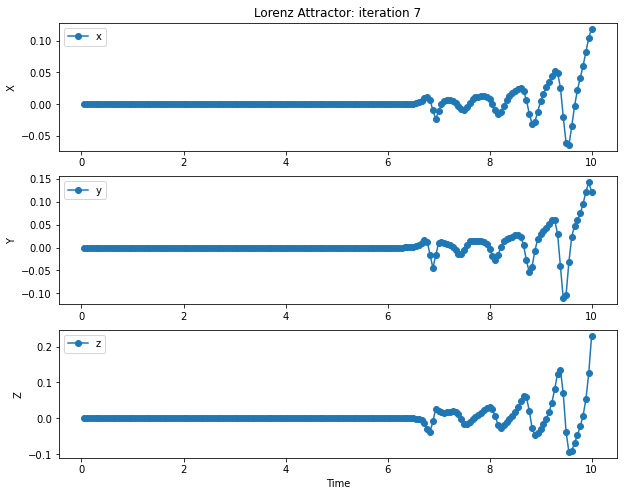

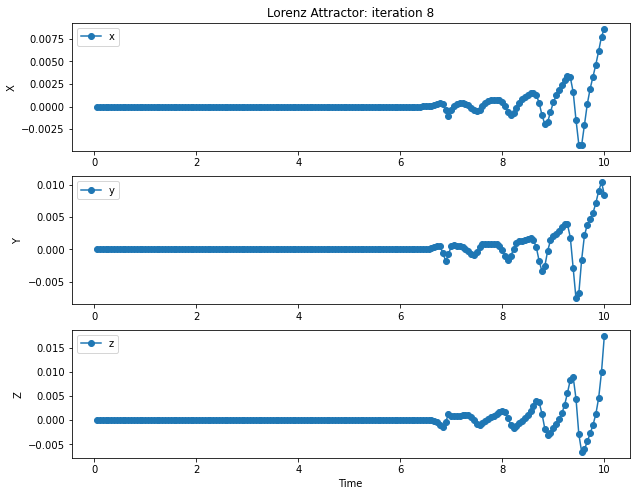

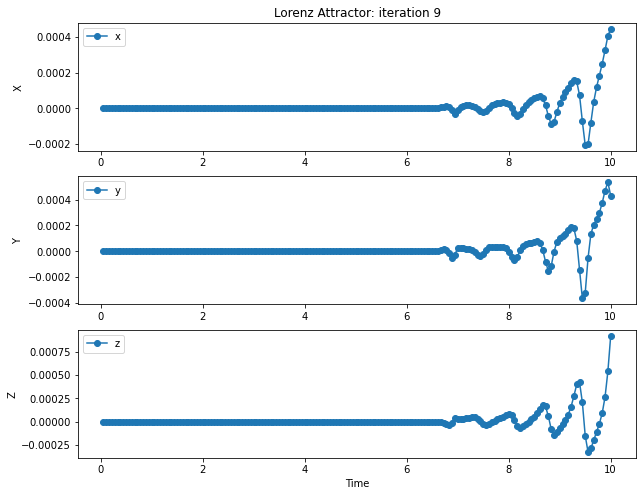

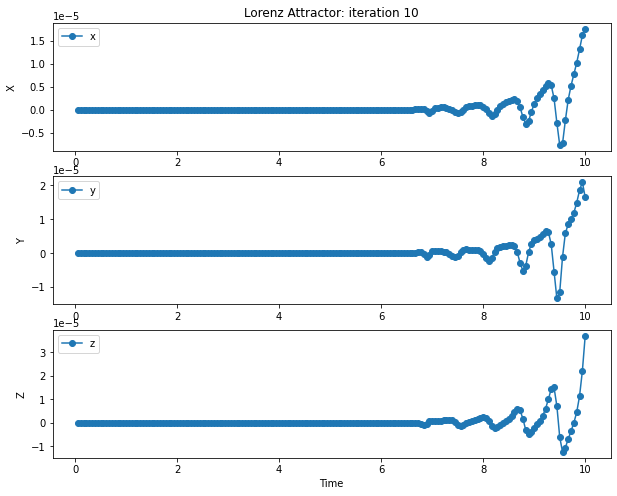

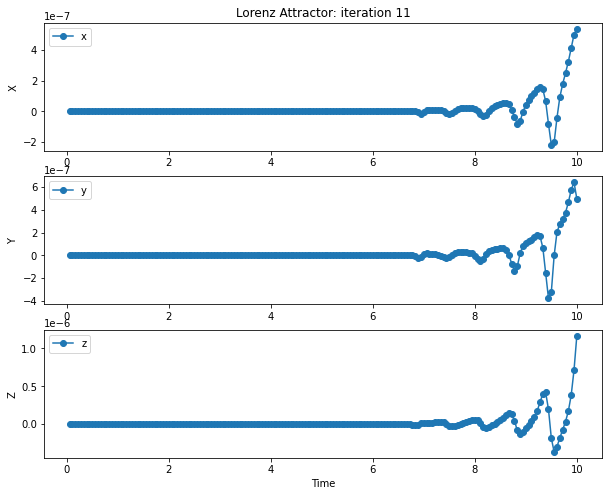

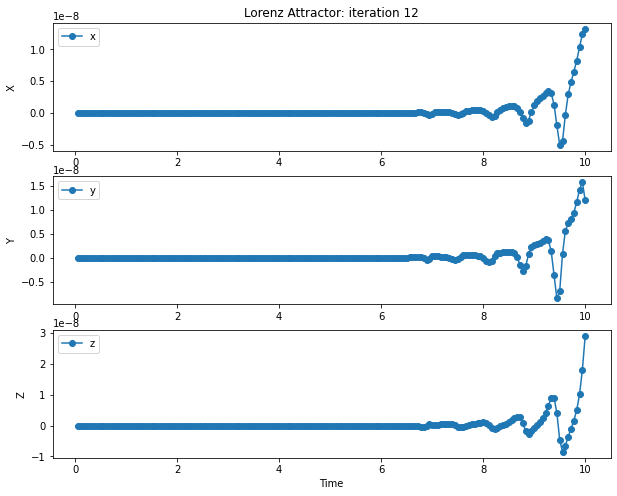

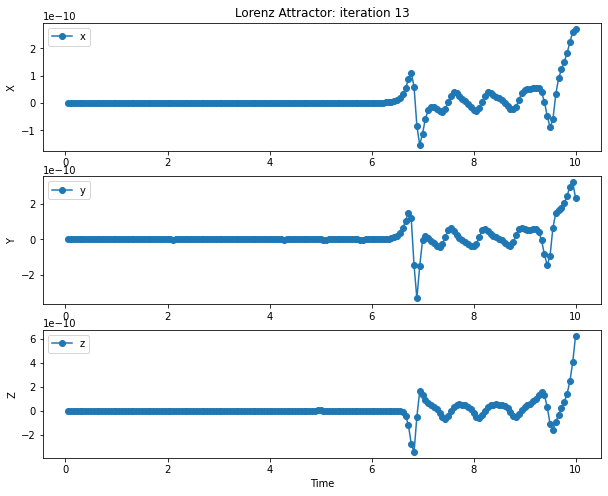

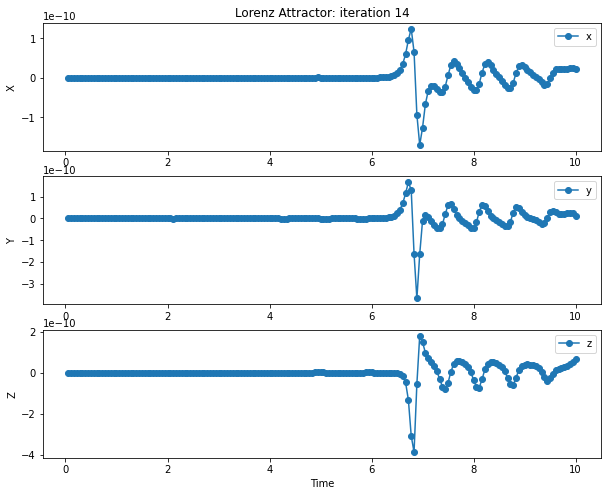

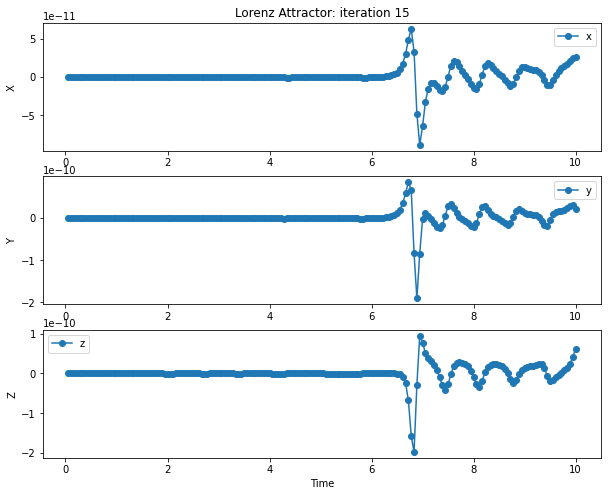

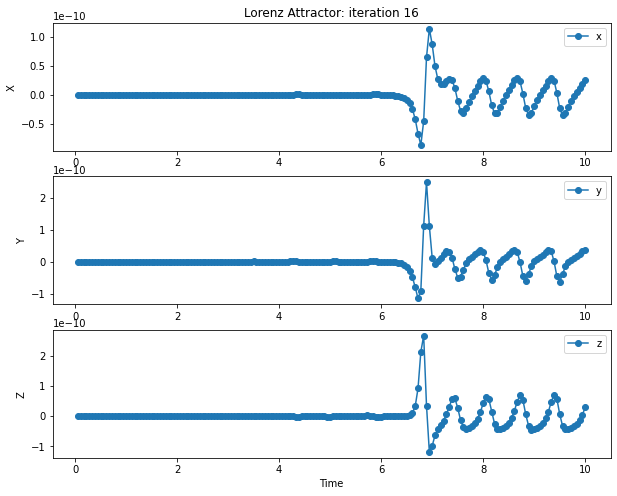

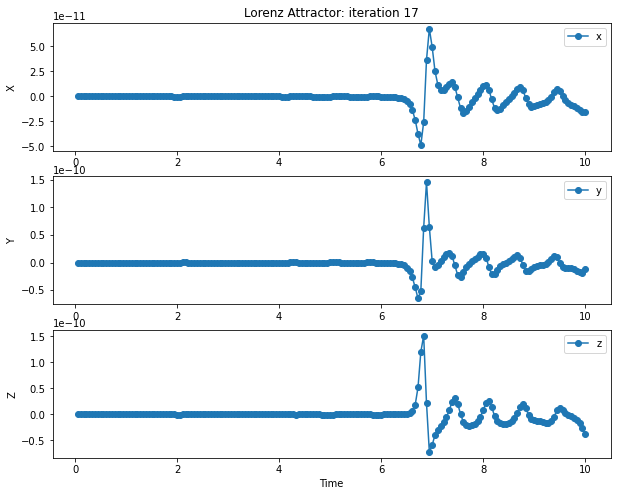

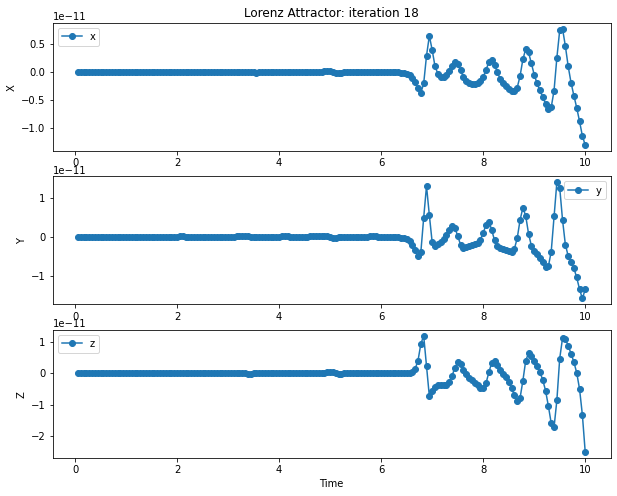

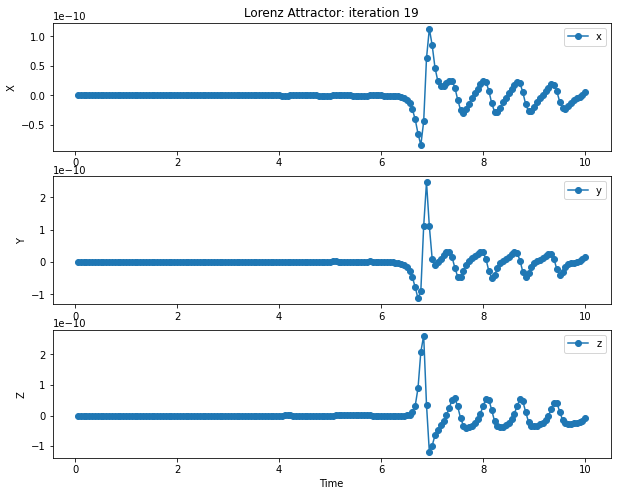

In [6]:
run_parareal_l63()